In [70]:
!pip install vaderSentiment
!pip install tabulate

In [71]:
from utils import *
from doc_utils import *

In [72]:
import warnings
import textblob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from collections import Counter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.rcParams['figure.figsize'] = [20, 8]

In [73]:
plt.rcParams['figure.figsize'] = [20, 8]

# Read tweets csv
df = pd.read_csv("../../data/Tweets3WeeksLocations.csv")

# Drop all-null rows if any
df.dropna(how='all', inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

/Users/ateendraramesh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,27,29,31,40,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
lead_days = 2
days_window = 5

labels = process_acled_csv("../../data/1900-01-01-2019-03-23-India.csv", 
                           top_locations=-1, 
                           start="23-feb-2019", 
                           end="19-mar-2019",
                          lead_days=lead_days,
                          days_window = days_window)

Data from 2019-02-23 00:00:00 to 2019-03-19 00:00:00  & Number of days - 25


In [76]:
clean = False
if not clean:
    df = clean_df(df)
    clean = True

Dropping 1 rows!


In [77]:
df.head(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,userfriends_count,userlisted_count,userfavourites_count,userverified,userstatuses_count,userfollowing,userfollow_request_sent,usercontributors_enabled,extractedlocation,finallocation
0,NaN,NaN,Tue Mar 05 04:05:13 +0000 2019,"[26, 264]","{'hashtags': [{'text': 'Telangana', 'indices':...",NaN,3.0,False,@Tejaswini7 @picchapakodi Telangana voters iss...,NaN,...,1378.0,22.0,2757.0,False,4178.0,NaN,NaN,False,"india, telangana",Hyderabad
1,NaN,NaN,Tue Mar 05 04:05:13 +0000 2019,"[26, 264]","{'hashtags': [{'text': 'Telangana', 'indices':...",NaN,3.0,False,@Tejaswini7 @picchapakodi Telangana voters iss...,NaN,...,1378.0,22.0,2757.0,False,4178.0,NaN,NaN,False,"india, telangana",India
2,NaN,NaN,Mon Mar 04 14:20:40 +0000 2019,"[0, 277]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1102574234897924096, 'id_str...",3.0,False,This kind of Atrocities are being faced by BJP...,NaN,...,1540.0,9.0,10906.0,False,32019.0,NaN,NaN,False,west bengal,Kolkata
3,NaN,NaN,Mon Mar 04 17:56:29 +0000 2019,"[0, 264]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1102628641668763650, 'id_str...",2.0,False,Pro-Naxal Forum Takes Out Anti-war Rally in Ko...,NaN,...,4.0,35.0,45.0,False,17589.0,NaN,NaN,False,"kolkata, west bengal",Kolkata
4,NaN,NaN,Mon Mar 04 06:42:10 +0000 2019,"[0, 123]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0.0,False,West Bengal police baton-charges BJP workers t...,NaN,...,747.0,2.0,0.0,False,10009.0,NaN,NaN,False,west bengal,Kolkata


In [78]:
df = get_tweet_sentiment(df)

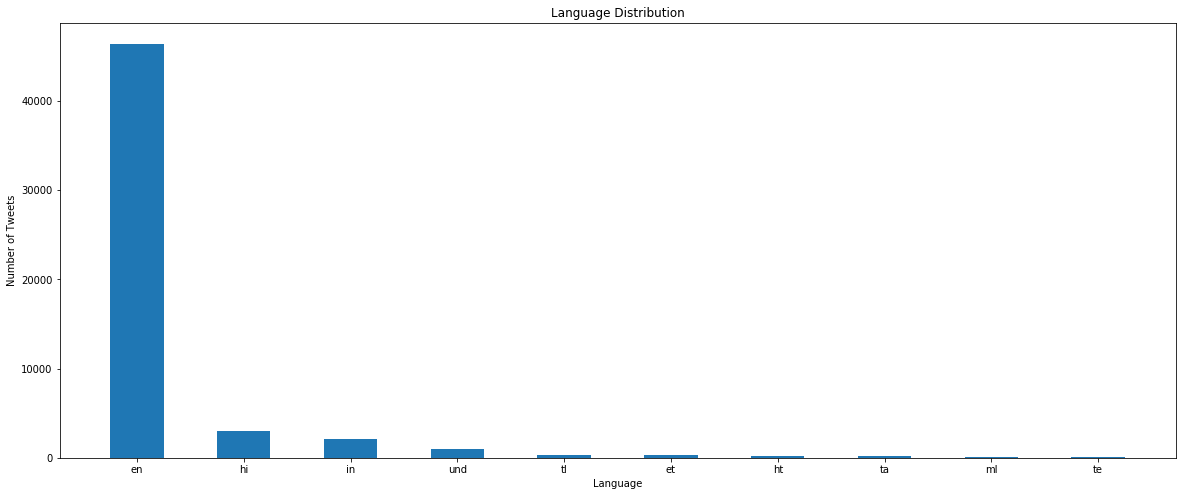

In [79]:
plot_counter(df['lang'], num_elements=10, xlabel="Language", ylabel="Number of Tweets", title="Language Distribution")

In [80]:
df['created_at'] = pd.to_datetime(df['created_at'])
# Sort by time created
df.sort_values(by=['created_at'], inplace=True)

In [81]:
start_date, end_date = df.iloc[0]['created_at'], df.iloc[-1]['created_at']
print(start_date, end_date)

location_date_dict = interleave_location_and_date(df, start_date, end_date)

2019-02-23 05:35:52 2019-03-19 23:52:51
Bathinda
Chandigarh
Ludhiana
Amritsar


/Users/ateendraramesh/Desktop/CSE635/Election-Violence-Prediction/notebooks/doc_utils.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['date'] = dates


Jalandhar
Patiala
Sangrur
Bengaluru
Delhi-New Delhi
Karnal
Gurgaon
India
Thiruvananthapuram
Dehradun
Lucknow
Pulwama
Hyderabad
Kolkata
Ahmedabad
Guwahati
Chennai
Tiruchirappalli
Coimbatore
Madurai
Salem
Puducherry
Imphal
Agartala
Jammu
Ranchi
Shimla
Patna
Jaipur
Srinagar


### Current Features
   * Number of tweets each day
   * Average pos, neg, neu and compound features
   * Tweet count with neg sentiment

### TODO
   * Hate speech
   * Violent speech

In [82]:
def get_features(date_dict):
    """
    Input: date_dict to compute features for each date
    Returns: Features for each date
    """
    features = []
    for date in date_dict:
        feature_row = []
        tweets = date_dict[date]
        if tweets is None:
            feature_row = [0] * 6
        else:
            feature_row.append(len(tweets))
            mean = tweets.mean()

            feature_row.extend([mean['pos'], mean['neg'], mean['neu'], mean['compound']])
            feature_row.append(len(tweets[tweets['neg'] > 0]))

        features.append(feature_row)
    return features

In [83]:
location_features_dict = {}
for location in location_date_dict:
    location_features_dict[location] = get_features(location_date_dict[location])
    print(location, "done")

Bathinda done
Chandigarh done
Ludhiana done
Amritsar done
Jalandhar done
Patiala done
Sangrur done
Bengaluru done
Delhi-New Delhi done
Karnal done
Gurgaon done
India done
Thiruvananthapuram done
Dehradun done
Lucknow done
Pulwama done
Hyderabad done
Kolkata done
Ahmedabad done
Guwahati done
Chennai done
Tiruchirappalli done
Coimbatore done
Madurai done
Salem done
Puducherry done
Imphal done
Agartala done
Jammu done
Ranchi done
Shimla done
Patna done
Jaipur done
Srinagar done


In [96]:
def make_predictions(location_features_dict, labels, model=None, permute=False):
    """
    Input - 
            location_features_dict - The dict mapping from location to features
            labels - Label dict generated from process_acled_csv(..)
            model - Specific sklearn model to evaluate/benchmark performance
            permute - Permute the data before train-test split
    Returns - None
    
    TODO - Integrate with nlp_utils.py
    """
    # Table for presenting on tabulate
    result_table = []
    
    # Suppress warnings for divide-by-zero error
    warnings.filterwarnings("ignore")
    
    # Compute intersection for locations present on both dicts
    common_locations = set(location_features_dict.keys()) & set(labels.keys())
    
    # Sorted for clarity
    common_locations = sorted(list(common_locations))
    
    for common_location in common_locations:
        # Get data and labels
        X, y = location_features_dict[common_location], labels[common_location]
        X, y = np.array(X), np.array(y)

        # Eliminate last days to match labels.shape
        X = X[:-(lead_days + days_window)]

        # Permute randomly if specified
        if permute:
            p = np.random.permutation(len(X))
            X, y = X[p], y[p]

        # Split data into train & test - 75% & 25%
        split = int(0.75 * len(X))
        xtrain, ytrain = X[:split], y[:split]
        xtest, ytest = X[split:], y[split:]
        
        # Default model
        if model is None:
            model = ExtraTreesClassifier(n_estimators=100)

        # Fit the train data
        model.fit(xtrain, ytrain)
    
        # Make predictions
        ypred = model.predict(xtest)
            
        # Compute metrics
        train_acc = model.score(xtrain, ytrain)
        test_acc = model.score(xtest, ytest)
        precision = precision_score(ytest, ypred)
        recall = recall_score(ytest, ypred)
        f1 = f1_score(ytest, ypred)

        # Add row to result_table
        result_row = [common_location,
                      np.round(train_acc, 2), np.round(test_acc, 2),
                      np.round(precision, 2), np.round(recall, 2),
                      np.round(f1, 2)]
        result_table.append(result_row)

    # Average stats
    # Turns out median is kind of useless
    result_table_copy = (np.array(result_table)[:, 1:]).astype(np.float32)
    averages = np.round(np.mean(result_table_copy, axis=0), 2)
    
    # Add them to the existing result table
    result_table.append(["Average"] + averages.tolist())
    
    print(tabulate(result_table,
               ["Location", "Train Accuracy", "Test Accuracy",
                   "Precision", "Recall", "F1 Score"],
               tablefmt="fancy_grid",
               stralign="center"))

    
    # Unsuppress warning
    warnings.filterwarnings("default")

In [97]:
make_predictions(location_features_dict, labels)

╒════════════════════╤══════════════════╤═════════════════╤═════════════╤══════════╤════════════╕
│      Location      │   Train Accuracy │   Test Accuracy │   Precision │   Recall │   F1 Score │
╞════════════════════╪══════════════════╪═════════════════╪═════════════╪══════════╪════════════╡
│      Agartala      │             1    │            0.4  │        0.4  │     1    │       0.57 │
├────────────────────┼──────────────────┼─────────────────┼─────────────┼──────────┼────────────┤
│     Ahmedabad      │             1    │            0.6  │        0    │     0    │       0    │
├────────────────────┼──────────────────┼─────────────────┼─────────────┼──────────┼────────────┤
│      Amritsar      │             1    │            1    │        1    │     1    │       1    │
├────────────────────┼──────────────────┼─────────────────┼─────────────┼──────────┼────────────┤
│      Bathinda      │             1    │            1    │        1    │     1    │       1    │
├───────────────────